### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

### Get Dataset

In [2]:
BATCH_SIZE = 16

# Transform the images from PIL to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar_10_train = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
cifar_10_test = torchvision.datasets.CIFAR10(root='./',train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


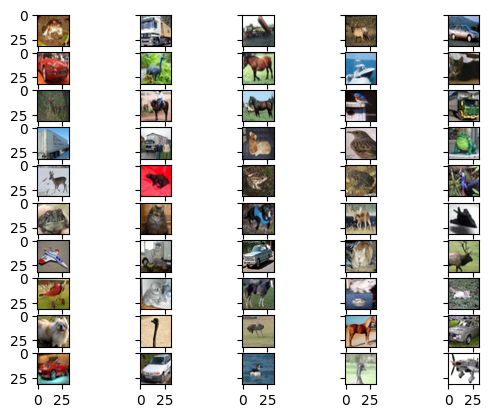

In [3]:
# Visualize 1 sample
sample_idx_ctr = 0
num_rows = 10
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, sharex=True, sharey=True)

for i in range(num_rows):
    for j in range(num_cols):

        img, label = cifar_10_train[sample_idx_ctr]
        ax[i,j].imshow(img.squeeze().permute(1,2,0))
        sample_idx_ctr += 1

### Sample Dataset

In [4]:
def get_torch_dataset(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.squeeze())
        labels.append(label)
    return torch.stack(images), torch.tensor(labels, dtype = torch.float32)

In [5]:
X_train, y_train = get_torch_dataset(cifar_10_train)
X_test, y_test = get_torch_dataset(cifar_10_test)

In [6]:
def get_sampled_dataset(X, y, n_samples=1000):
    X_sampled = []
    y_sampled = []

    for unique_label in torch.unique(y):

        # get all examples of 1 class.
        class_examples = X[y == unique_label]
        
        # generate indices and randomly permutate them.
        indices = torch.arange(class_examples.shape[0])
        shuffled_indices = torch.randperm(indices.shape[0])
        
        # select top k samples and use it as dataset.
        shuffled_indices = shuffled_indices[:n_samples]
        selected_samples = class_examples[shuffled_indices]

        selected_labels = torch.full((n_samples,), unique_label)

        X_sampled.append(selected_samples)
        y_sampled.append(selected_labels)

    return torch.cat(X_sampled, dim=0), torch.cat(y_sampled)

In [7]:
X_train_sampled, y_train_sampled = get_sampled_dataset(X_train, y_train, 1000)
X_test_sampled, y_test_sampled = get_sampled_dataset(X_test, y_test, 1000)

In [8]:
X_train_sampled.shape, y_train_sampled.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000]))

In [9]:
X_test_sampled.shape, y_test_sampled.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000]))

### Shuffle Dataset

In [10]:
# generate indices and randomly permutate them.
indices = torch.arange(X_train_sampled.shape[0])
shuffled_indices = torch.randperm(indices.shape[0])

# select top k samples and use it as dataset.
X_train_sampled = X_train_sampled[shuffled_indices]
y_train_sampled = y_train_sampled[shuffled_indices]

# generate indices and randomly permutate them.
indices = torch.arange(X_test_sampled.shape[0])
shuffled_indices = torch.randperm(indices.shape[0])

# select top k samples and use it as dataset.
X_test_sampled = X_test_sampled[shuffled_indices]
y_test_sampled = y_test_sampled[shuffled_indices]

### Normalize Dataset

In [11]:
def normalize_images(images):
    mean = torch.mean(images, axis=(1, 2, 3), keepdims=True)
    std = torch.std(images, axis=(1, 2, 3), keepdims=True)
    normalized_images = (images - mean) / std
    return normalized_images

In [12]:
x_train = normalize_images(X_train_sampled)
x_test = normalize_images(X_test_sampled)
y_train = y_train_sampled
y_test = y_test_sampled

In [13]:
# function to convert y output vector of size n,1 to onhot vector of size n,10
def convert_to_one_hot(labels):
    unique = torch.unique(labels)
    onehot = torch.zeros((labels.shape[0], unique.shape[0]))
    onehot[torch.arange(labels.shape[0]), labels.int()] = 1.
    return onehot


y_train_oh = convert_to_one_hot(y_train)
y_test_oh = convert_to_one_hot(y_test)

### Resnet Class and Baseline

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

test_acc = []
train_acc = []

# Training loop
num_epochs = 100

for epoch in range(num_epochs):

    i = 0
    iter = 0
    batch_size = 500
    
    while i < x_train.shape[0]:
        model.train()
        
        inputs = x_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].type(torch.LongTensor).to(device)
        labels_oh = y_train_oh[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels_oh)
        loss.backward()
        optimizer.step()

        i += batch_size
        iter += 1

        if (iter + 1) % 5 == 0:
            print('[epoch: %d, iter: %d]-loss: %.3f' % (epoch + 1, iter + 1,loss.item() / batch_size))

    # Evaluation on the test set
    model.eval()

    # Test Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_test.to(device)
        labels = y_test.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    print('Epoch %d: Accuracy on test set: %.2f %%' % (epoch + 1, accuracy))

    # Train Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_train.to(device)
        labels = y_train.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print('Epoch %d: Accuracy on Train set: %.2f %%' % (epoch + 1, accuracy))

print('Training completed!')

[epoch: 1, iter: 5]-loss: 0.005
[epoch: 1, iter: 10]-loss: 0.004
[epoch: 1, iter: 15]-loss: 0.004
[epoch: 1, iter: 20]-loss: 0.004
Epoch 1: Accuracy on test set: 22.34 %
Epoch 1: Accuracy on Train set: 23.78 %
[epoch: 2, iter: 5]-loss: 0.003
[epoch: 2, iter: 10]-loss: 0.003
[epoch: 2, iter: 15]-loss: 0.003
[epoch: 2, iter: 20]-loss: 0.003
Epoch 2: Accuracy on test set: 36.08 %
Epoch 2: Accuracy on Train set: 55.31 %
[epoch: 3, iter: 5]-loss: 0.002
[epoch: 3, iter: 10]-loss: 0.002
[epoch: 3, iter: 15]-loss: 0.002
[epoch: 3, iter: 20]-loss: 0.002
Epoch 3: Accuracy on test set: 39.74 %
Epoch 3: Accuracy on Train set: 82.46 %
[epoch: 4, iter: 5]-loss: 0.001
[epoch: 4, iter: 10]-loss: 0.001
[epoch: 4, iter: 15]-loss: 0.001
[epoch: 4, iter: 20]-loss: 0.001
Epoch 4: Accuracy on test set: 39.74 %
Epoch 4: Accuracy on Train set: 90.49 %
[epoch: 5, iter: 5]-loss: 0.001
[epoch: 5, iter: 10]-loss: 0.001
[epoch: 5, iter: 15]-loss: 0.001
[epoch: 5, iter: 20]-loss: 0.001
Epoch 5: Accuracy on test set

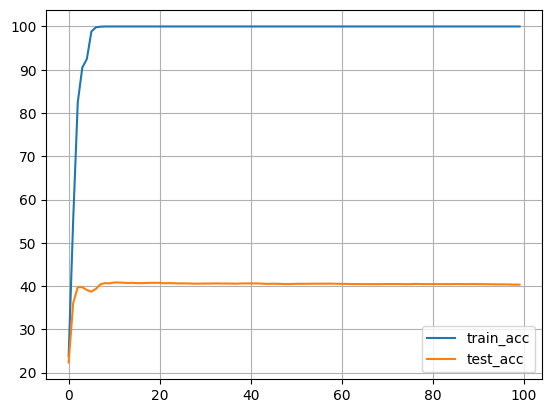

In [16]:
plt.figure()
plt.plot(torch.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(torch.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid()
plt.legend()
plt.show()

We can achieve upto 100% accuracy on Train set and 40% accuracy on Test set

### Mixup Augmentation

In [17]:
def mixup_data(inputs, labels, alpha):

    inputs = inputs.clone()
    labels = labels.clone()
    
    batch_size = inputs.shape[0]

    beta_distribution = np.random.beta(alpha,alpha,batch_size)
    lam = torch.Tensor(beta_distribution)

    # Permute the inputs and labels
    index = torch.randperm(batch_size)
    mixed_inputs = lam.view(batch_size, 1, 1, 1) * inputs + (1 - lam).view(batch_size, 1, 1, 1) * inputs[index, :]
    mixed_labels = lam.view(batch_size, 1) * labels + (1 - lam).view(batch_size, 1) * labels[index]

    return mixed_inputs, mixed_labels

mixed_up_images, mixed_up_labels = mixup_data(x_train[:100], y_train_oh[:100], 0.2)

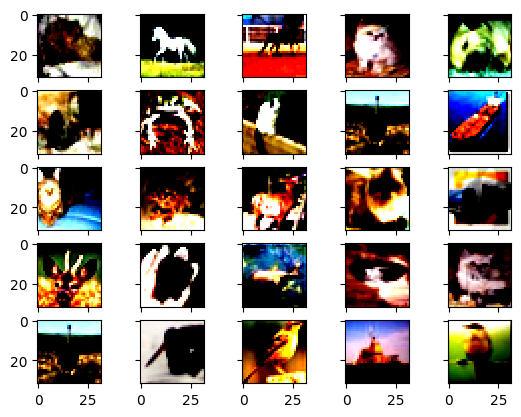

In [18]:
# Visualize 1 sample
sample_idx_ctr = 0
num_rows = 5
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, sharex=True, sharey=True)

for i in range(num_rows):
    for j in range(num_cols):

        img = mixed_up_images[sample_idx_ctr]
        ax[i,j].imshow(img.squeeze().permute(1,2,0))
        sample_idx_ctr += 1

[epoch: 1]-loss: 0.004
Epoch 1: Accuracy on test set: 22.37 %
Epoch 1: Accuracy on Train set: 23.12 %
Epoch 2: Accuracy on test set: 35.66 %
Epoch 2: Accuracy on Train set: 51.43 %
Epoch 3: Accuracy on test set: 39.49 %
Epoch 3: Accuracy on Train set: 68.52 %
Epoch 4: Accuracy on test set: 40.65 %
Epoch 4: Accuracy on Train set: 77.51 %
Epoch 5: Accuracy on test set: 40.87 %
Epoch 5: Accuracy on Train set: 84.42 %
[epoch: 6]-loss: 0.002
Epoch 6: Accuracy on test set: 41.46 %
Epoch 6: Accuracy on Train set: 90.06 %
Epoch 7: Accuracy on test set: 41.93 %
Epoch 7: Accuracy on Train set: 93.73 %
Epoch 8: Accuracy on test set: 41.28 %
Epoch 8: Accuracy on Train set: 96.83 %
Epoch 9: Accuracy on test set: 41.25 %
Epoch 9: Accuracy on Train set: 98.27 %
Epoch 10: Accuracy on test set: 41.61 %
Epoch 10: Accuracy on Train set: 99.15 %
[epoch: 11]-loss: 0.001
Epoch 11: Accuracy on test set: 41.35 %
Epoch 11: Accuracy on Train set: 99.59 %
Epoch 12: Accuracy on test set: 41.22 %
Epoch 12: Accurac

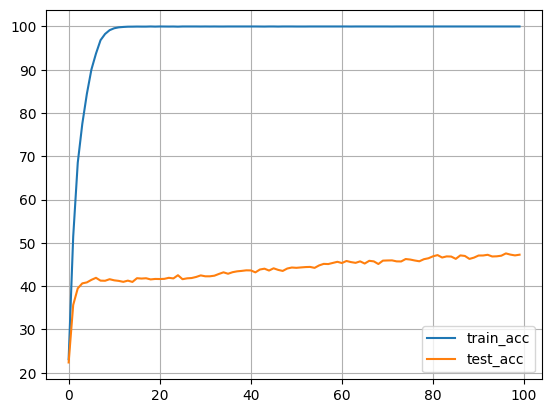

[epoch: 1]-loss: 0.004
Epoch 1: Accuracy on test set: 25.57 %
Epoch 1: Accuracy on Train set: 26.75 %
Epoch 2: Accuracy on test set: 36.64 %
Epoch 2: Accuracy on Train set: 51.10 %
Epoch 3: Accuracy on test set: 38.86 %
Epoch 3: Accuracy on Train set: 64.66 %
Epoch 4: Accuracy on test set: 40.67 %
Epoch 4: Accuracy on Train set: 72.67 %
Epoch 5: Accuracy on test set: 40.96 %
Epoch 5: Accuracy on Train set: 78.94 %
[epoch: 6]-loss: 0.003
Epoch 6: Accuracy on test set: 42.16 %
Epoch 6: Accuracy on Train set: 84.79 %
Epoch 7: Accuracy on test set: 41.97 %
Epoch 7: Accuracy on Train set: 89.52 %
Epoch 8: Accuracy on test set: 42.37 %
Epoch 8: Accuracy on Train set: 92.34 %
Epoch 9: Accuracy on test set: 42.45 %
Epoch 9: Accuracy on Train set: 95.20 %
Epoch 10: Accuracy on test set: 42.52 %
Epoch 10: Accuracy on Train set: 96.84 %
[epoch: 11]-loss: 0.002
Epoch 11: Accuracy on test set: 43.20 %
Epoch 11: Accuracy on Train set: 98.11 %
Epoch 12: Accuracy on test set: 42.61 %
Epoch 12: Accurac

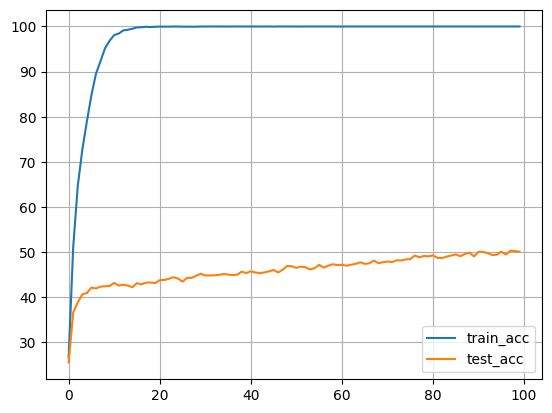

In [19]:
# Define loss function and optimizer


for alpha in [0.2, 0.4]:
    # Training loop
    num_epochs = 100

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the ResNet-18 model
    model = torchvision.models.resnet18(pretrained=False)
    num_classes = 10

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    model.eval()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    test_acc = []
    train_acc = []

    for epoch in range(num_epochs):

        i = 0
        iter = 0
        batch_size = 500
        
        while i < x_train.shape[0]:
            model.train()
            
            inputs = x_train[i:i+batch_size]
            labels = y_train[i:i+batch_size].type(torch.LongTensor)
            labels_oh = y_train_oh[i:i+batch_size]

            inputs, labels_oh = mixup_data(inputs, labels_oh, alpha)
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_oh = labels_oh.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels_oh)
            loss.backward()
            optimizer.step()

            i += batch_size
            iter += 1

        if epoch % 5 == 0:
            print('[epoch: %d]-loss: %.3f' % (epoch + 1,loss.item() / batch_size))

        # Evaluation on the test set
        model.eval()

        # Test Accuracy
        correct = 0
        total = 0
        with torch.no_grad():

            inputs = x_test.to(device)
            labels = y_test.type(torch.LongTensor).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_acc.append(accuracy)
        print('Epoch %d: Accuracy on test set: %.2f %%' % (epoch + 1, accuracy))

        # Train Accuracy
        correct = 0
        total = 0
        with torch.no_grad():

            inputs = x_train.to(device)
            labels = y_train.type(torch.LongTensor).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        train_acc.append(accuracy)
        print('Epoch %d: Accuracy on Train set: %.2f %%' % (epoch + 1, accuracy))

    print('Training completed!')

    plt.figure()
    plt.plot(torch.arange(len(train_acc)), train_acc, label='train_acc')
    plt.plot(torch.arange(len(test_acc)), test_acc, label='test_acc')
    plt.grid()
    plt.legend()
    plt.show()

For Alpha = 0.2.
We can achieve upto 100% accuracy on Train set and 47% accuracy on Test set

For Alpha = 0.4.
We can achieve upto 100% accuracy on Train set and 50% accuracy on Test set

### Cutout Augmentation

In [20]:
def cutout(inputs, length=16, p=0.5):

    inputs = inputs.clone()
    
    batch_size, channels, height, width = inputs.size()

    for img in inputs:

        if np.random.random() > p:
            continue

        # Generate random center coordinates for cutout position
        center_x = np.random.randint(0, width)
        center_y = np.random.randint(0, height)

        # Calculate cutout region boundaries
        left = max(0, center_x - length // 2)
        upper = max(0, center_y - length // 2)
        right = min(width, center_x + length // 2)
        lower = min(height, center_y + length // 2)

        # Apply cutout to each image in the batch
        for i in range(batch_size):
            img[:, upper:lower, left:right] = 0.

    return inputs

cutout_images = cutout(x_train[:100], 16,0.5)

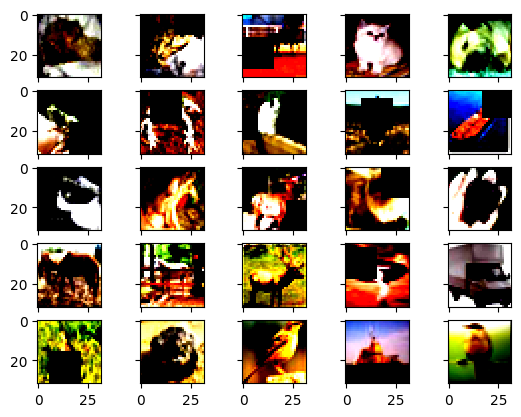

In [21]:
# Visualize 1 sample
sample_idx_ctr = 0
num_rows = 5
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, sharex=True, sharey=True)

for i in range(num_rows):
    for j in range(num_cols):

        img = cutout_images[sample_idx_ctr]
        ax[i,j].imshow(img.squeeze().permute(1,2,0))
        sample_idx_ctr += 1

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

test_acc = []
train_acc = []

# Training loop
num_epochs = 100

for epoch in range(num_epochs):

    i = 0
    iter = 0
    batch_size = 500
    
    while i < x_train.shape[0]:
        model.train()
        
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size].type(torch.LongTensor).to(device)
        labels_oh = y_train_oh[i:i+batch_size].to(device)
        inputs = cutout(inputs, 16, 0.5)
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels_oh)
        loss.backward()
        optimizer.step()

        i += batch_size
        iter += 1

        if (iter + 1) % 5 == 0:
            print('[epoch: %d, iter: %d]-loss: %.3f' % (epoch + 1, iter + 1,loss.item() / batch_size))

    # Evaluation on the test set
    model.eval()

    # Test Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_test.to(device)
        labels = y_test.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    print('Epoch %d: Accuracy on test set: %.2f %%' % (epoch + 1, accuracy))

    # Train Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_train.to(device)
        labels = y_train.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print('Epoch %d: Accuracy on Train set: %.2f %%' % (epoch + 1, accuracy))

print('Training completed!')

[epoch: 1, iter: 5]-loss: 0.005
[epoch: 1, iter: 10]-loss: 0.004
[epoch: 1, iter: 15]-loss: 0.004
[epoch: 1, iter: 20]-loss: 0.004
Epoch 1: Accuracy on test set: 21.77 %
Epoch 1: Accuracy on Train set: 22.60 %
[epoch: 2, iter: 5]-loss: 0.003
[epoch: 2, iter: 10]-loss: 0.003
[epoch: 2, iter: 15]-loss: 0.003
[epoch: 2, iter: 20]-loss: 0.003
Epoch 2: Accuracy on test set: 36.73 %
Epoch 2: Accuracy on Train set: 50.83 %
[epoch: 3, iter: 5]-loss: 0.003
[epoch: 3, iter: 10]-loss: 0.003
[epoch: 3, iter: 15]-loss: 0.003
[epoch: 3, iter: 20]-loss: 0.003
Epoch 3: Accuracy on test set: 39.82 %
Epoch 3: Accuracy on Train set: 66.86 %
[epoch: 4, iter: 5]-loss: 0.003
[epoch: 4, iter: 10]-loss: 0.003
[epoch: 4, iter: 15]-loss: 0.003
[epoch: 4, iter: 20]-loss: 0.002
Epoch 4: Accuracy on test set: 41.58 %
Epoch 4: Accuracy on Train set: 76.59 %
[epoch: 5, iter: 5]-loss: 0.002
[epoch: 5, iter: 10]-loss: 0.002
[epoch: 5, iter: 15]-loss: 0.002
[epoch: 5, iter: 20]-loss: 0.002
Epoch 5: Accuracy on test set

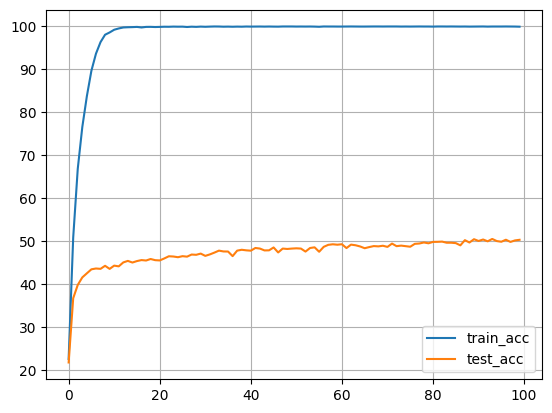

In [24]:
plt.figure()
plt.plot(torch.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(torch.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid()
plt.legend()
plt.show()

We can achieve upto 100% accuracy on Train set and 50% accuracy on Test set

### Standard Augmentation

In [25]:
import torch
import random

def random_shift_and_flip(images, K):
    
    images = images.clone()

    batch_size, channels, height, width = images.size()
    shifted_images = torch.zeros_like(images)
    
    for i in range(batch_size):
        image = images[i]
        k1 = random.randint(-K, K)
        k2 = random.randint(-K, K)
        
        # Apply horizontal shift
        if k1 > 0:
            shifted_images[i, :, :, k1:] = image[:, :, :-k1]
        elif k1 < 0:
            shifted_images[i, :, :, :k1] = image[:, :, -k1:]
        else:
            shifted_images[i] = image
        
        # Apply vertical shift
        if k2 > 0:
            shifted_images[i, :, k2:, :] = shifted_images[i, :, :-k2, :]
        elif k2 < 0:
            shifted_images[i, :, :k2, :] = shifted_images[i, :, -k2:, :]
        
        # Apply horizontal flip with 50% probability
        for image in shifted_images:
            if random.random() < 0.5:
                image = torch.flip(image, [2])
    
    return shifted_images

K = 4  # Define the value of K

shifted_and_flipped_images = random_shift_and_flip(x_train[:100], K)


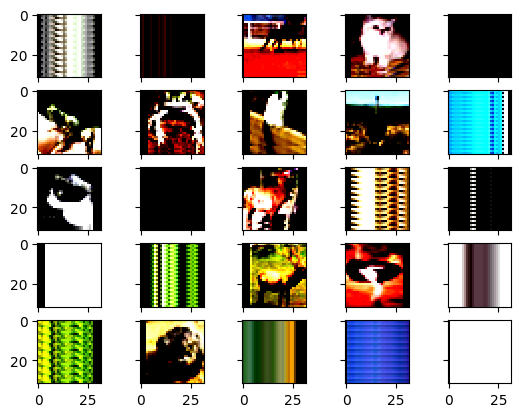

In [26]:
# Visualize 1 sample
sample_idx_ctr = 0
num_rows = 5
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, sharex=True, sharey=True)

for i in range(num_rows):
    for j in range(num_cols):

        img = shifted_and_flipped_images[sample_idx_ctr]
        ax[i,j].imshow(img.squeeze().permute(1,2,0))
        sample_idx_ctr += 1

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

test_acc = []
train_acc = []

# Training loop
num_epochs = 100

for epoch in range(num_epochs):

    i = 0
    iter = 0
    batch_size = 500
    
    while i < x_train.shape[0]:
        model.train()
        
        inputs = x_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].type(torch.LongTensor).to(device)
        labels_oh = y_train_oh[i:i+batch_size].to(device)

        inputs = random_shift_and_flip(inputs, 4)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels_oh)
        loss.backward()
        optimizer.step()

        i += batch_size
        iter += 1

        if (iter + 1) % 5 == 0:
            print('[epoch: %d, iter: %d]-loss: %.3f' % (epoch + 1, iter + 1,loss.item() / batch_size))

    # Evaluation on the test set
    model.eval()

    # Test Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_test.to(device)
        labels = y_test.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    print('Epoch %d: Accuracy on test set: %.2f %%' % (epoch + 1, accuracy))

    # Train Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_train.to(device)
        labels = y_train.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print('Epoch %d: Accuracy on Train set: %.2f %%' % (epoch + 1, accuracy))

print('Training completed!')

[epoch: 1, iter: 5]-loss: 0.005
[epoch: 1, iter: 10]-loss: 0.004
[epoch: 1, iter: 15]-loss: 0.004
[epoch: 1, iter: 20]-loss: 0.004
Epoch 1: Accuracy on test set: 22.58 %
Epoch 1: Accuracy on Train set: 23.73 %
[epoch: 2, iter: 5]-loss: 0.004
[epoch: 2, iter: 10]-loss: 0.004
[epoch: 2, iter: 15]-loss: 0.004
[epoch: 2, iter: 20]-loss: 0.004
Epoch 2: Accuracy on test set: 35.52 %
Epoch 2: Accuracy on Train set: 37.23 %
[epoch: 3, iter: 5]-loss: 0.004
[epoch: 3, iter: 10]-loss: 0.004
[epoch: 3, iter: 15]-loss: 0.004
[epoch: 3, iter: 20]-loss: 0.003
Epoch 3: Accuracy on test set: 38.89 %
Epoch 3: Accuracy on Train set: 41.81 %
[epoch: 4, iter: 5]-loss: 0.003
[epoch: 4, iter: 10]-loss: 0.004
[epoch: 4, iter: 15]-loss: 0.003
[epoch: 4, iter: 20]-loss: 0.003
Epoch 4: Accuracy on test set: 41.83 %
Epoch 4: Accuracy on Train set: 44.89 %
[epoch: 5, iter: 5]-loss: 0.003
[epoch: 5, iter: 10]-loss: 0.003
[epoch: 5, iter: 15]-loss: 0.003
[epoch: 5, iter: 20]-loss: 0.003
Epoch 5: Accuracy on test set

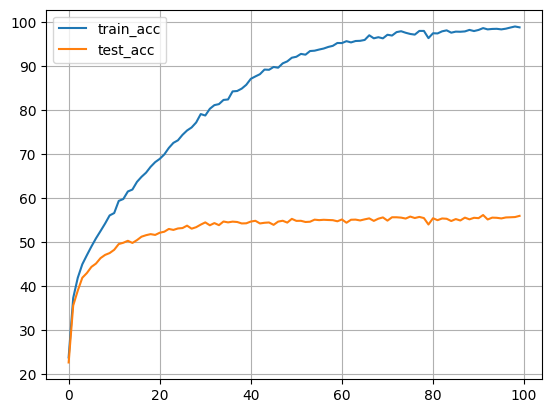

In [29]:
plt.figure()
plt.plot(torch.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(torch.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid()
plt.legend()
plt.show()

We can achieve upto 100% accuracy on Train set and 56% accuracy on Test set

### Combined

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
num_classes = 10

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

test_acc = []
train_acc = []

# Training loop
num_epochs = 100

for epoch in range(num_epochs):

    i = 0
    iter = 0
    batch_size = 500
    
    while i < x_train.shape[0]:
        model.train()
        
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size].type(torch.LongTensor)
        labels_oh = y_train_oh[i:i+batch_size]

        inputs = cutout(inputs, 16, 0.5)
        inputs = random_shift_and_flip(inputs, 4)
        inputs, labels_oh = mixup_data(inputs, labels_oh, 0.4)


        inputs = inputs.to(device)
        labels = labels.to(device)
        labels_oh = labels_oh.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels_oh)
        loss.backward()
        optimizer.step()

        i += batch_size
        iter += 1

        if (iter + 1) % 5 == 0:
            print('[epoch: %d, iter: %d]-loss: %.3f' % (epoch + 1, iter + 1,loss.item() / batch_size))

    # Evaluation on the test set
    model.eval()

    # Test Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_test.to(device)
        labels = y_test.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    print('Epoch %d: Accuracy on test set: %.2f %%' % (epoch + 1, accuracy))

    # Train Accuracy
    correct = 0
    total = 0
    with torch.no_grad():

        inputs = x_train.to(device)
        labels = y_train.type(torch.LongTensor).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print('Epoch %d: Accuracy on Train set: %.2f %%' % (epoch + 1, accuracy))

print('Training completed!')

[epoch: 1, iter: 5]-loss: 0.005
[epoch: 1, iter: 10]-loss: 0.005
[epoch: 1, iter: 15]-loss: 0.004
[epoch: 1, iter: 20]-loss: 0.004
Epoch 1: Accuracy on test set: 21.77 %
Epoch 1: Accuracy on Train set: 21.64 %
[epoch: 2, iter: 5]-loss: 0.004
[epoch: 2, iter: 10]-loss: 0.004
[epoch: 2, iter: 15]-loss: 0.004
[epoch: 2, iter: 20]-loss: 0.004
Epoch 2: Accuracy on test set: 32.00 %
Epoch 2: Accuracy on Train set: 32.53 %
[epoch: 3, iter: 5]-loss: 0.004
[epoch: 3, iter: 10]-loss: 0.004
[epoch: 3, iter: 15]-loss: 0.004
[epoch: 3, iter: 20]-loss: 0.004
Epoch 3: Accuracy on test set: 32.63 %
Epoch 3: Accuracy on Train set: 34.23 %
[epoch: 4, iter: 5]-loss: 0.004
[epoch: 4, iter: 10]-loss: 0.004
[epoch: 4, iter: 15]-loss: 0.004
[epoch: 4, iter: 20]-loss: 0.004
Epoch 4: Accuracy on test set: 34.24 %
Epoch 4: Accuracy on Train set: 35.82 %
[epoch: 5, iter: 5]-loss: 0.004
[epoch: 5, iter: 10]-loss: 0.004
[epoch: 5, iter: 15]-loss: 0.004
[epoch: 5, iter: 20]-loss: 0.004
Epoch 5: Accuracy on test set

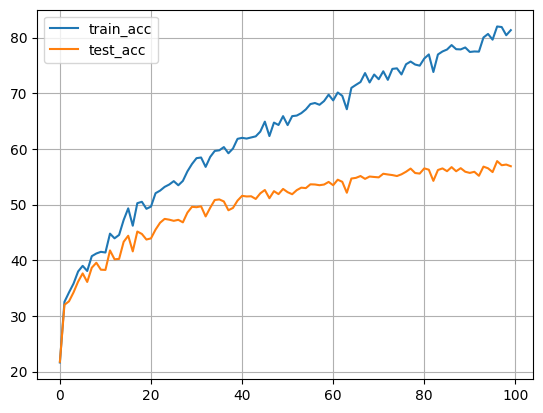

In [32]:
plt.figure()
plt.plot(torch.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(torch.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid()
plt.legend()
plt.show()

For Alpha = 0.4 set for combined augmentation
We can achieve upto 100% accuracy on Train set and 58% accuracy on Test set

We can see a slight improvement in the classification with all the three augmentations combined.

## Role of Data Augmentation

Data augmentation is a good regularization option and its helps model generalize better to have improved results. It also helps the model to converge faster.

It increase the test accuracy by atleast 10% in some cases with upto 18% when combined together.

However, for train accuracy, we see a reduction in train accuracy, which means that the model is generalizing better and is not prone to overfitting.

The model converges to solution faster and gets a better solution without being stuck in a local minima.

The test accuracy is higher and loss converges faster.